In [1]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

/home/vco/Projects/pm4py-dcr/notebooks
/home/vco/Projects/pm4py-dcr


In [2]:
import pm4py
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
from scipy import stats
from pm4py.algo.discovery.dcr_discover import algorithm as alg
from pm4py.objects.dcr.exporter import exporter as dcr_exporter
import networkx as nx

In [4]:
A,B,X,Y,Z = 'A','B','X','Y','Z'
dcr1 = {'events': {A,B,X,Y,Z},
       'excludesTo': {
           X: {X,Y,A,B},
           Y: {Y,X,A},
           Z: {A},
           A: {X}
       }}
# result should be {X,Y} or {A,X} but A is not self-excluding itself

In [5]:
dcr2 = {'events': {A,B,X,Y,Z},
       'excludesTo': {
           X: {Y,X,Z},
           Y: {X,Z,Y},
           Z: {Y,Z,X},
           A: {B,A,Z},
           B: {B,A}
       }}
# result should be {X,Y,Z}, {A,B}

In [12]:
# dfs approach for mutual exclusion: find_largest
def find_largest(e,E_stack,graph,S=None):
    # remove e from E
    if e in E_stack:
        E_stack.remove(e)
    # add e to a subprocess candidate S
    if S is None:
        S = set()
    S.add(e)
    # loop through the events in E using e_prime
    while len(E_stack)>0:
        e_prime = E_stack.pop()
        # check if e_prime is mutually excluded by all events in S
        if (e_prime in graph and e in graph[e_prime]) and (e in graph and e_prime in graph[e]):
            # if yes then GOTO begin function (add e_prime to the set S and remove e_prime from E)
            find_largest(e_prime,E_stack,graph,S)

    # return S
    return S

# dfs approach for mutual exclusion: get_subprocesses
def get_subprocesses(dcr):
    # initialize an empty dict of subprocesses
    sp = {}
    i = 0
    # keep only the mutually excluded events E and the related graph
    graph = dcr['excludesTo']
    E = set()
    for k,v in graph.items():
        E.add(k)
        E = E.union(v)
    for e in E:
        E_stack = []
        for j in E:
            E_stack.append(j)
        # call function1 with e E graph return S
        print(e)
        s = find_largest(e,E_stack,graph)
        # if S > 1 add to subprocess list
        if len(s) > 1:
            print(s)
            already_there = False
            intersecting_events = False
            for k, v in sp.items():
                common_events = v.intersection(s)
                if len(common_events) > 0:
                    intersecting_events = True
                    if len(s) > len(v):
                        sp[k] = s
                    break

                if v == s:
                    already_there = True
                    break

            if not already_there and not intersecting_events:
                sp[f'S{i}'] = s
                i = i + 1

    # return subprocess list
    return sp

In [8]:
event_log_file = '/home/vco/Datasets/Sepsis Cases - Event Log.xes'
dcrxml_file = 'models/sepsis_sp.xml'
dcr_title = 'Sepsis Cases'
event_log = pm4py.read_xes(event_log_file, return_legacy_log_object=True)
reference_event_log = deepcopy(event_log)

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 1960.33it/s]


In [13]:
reference_dcr, la = alg.apply(reference_event_log,alg.DCR_BASIC, timed=False)
get_subprocesses(reference_dcr)

Release C
{'Release C', 'Release E', 'Release B', 'Release A', 'Release D'}
ER Registration
Return ER
{'Release C', 'Release B', 'Return ER', 'Release E'}
Admission NC
ER Sepsis Triage
Release E
{'Release E', 'Release B', 'Return ER', 'Release A', 'Release D'}
IV Liquid
IV Antibiotics
Admission IC
Leucocytes
Release B
{'Release C', 'Release E', 'Release B', 'Release A', 'Release D'}
ER Triage
LacticAcid
Release A
{'Release C', 'Release E', 'Release B', 'Release A', 'Release D'}
Release D
{'Release C', 'Release E', 'Release B', 'Release A', 'Release D'}
CRP


/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


{'S0': {'Release A', 'Release B', 'Release C', 'Release D', 'Release E'}}

In [10]:
spme_dcr, spme_log = alg.apply(event_log,alg.DCR_SUBPROCESS_ME,
                            findAdditionalConditions=True,
                            inBetweenRels=False,
                            timed=False)

{'S0': {'Release C', 'Release E', 'Release B', 'Release A', 'Release D'}}


In [22]:
from pm4py.algo.evaluation.simplicity.variants import dcr_relations as dcr_simplicity
r_dcr = dcr_simplicity.get_simplicity(reference_dcr)
spme_dcr =dcr_simplicity.get_simplicity(spme_dcr)

In [19]:
dcr_exporter.apply(dcr_graph=spme_dcr,
                   path='models/sepsis_sp_me.xml',
                   variant=dcr_exporter.DCR_XML_SIMPLE,
                   dcr_title=dcr_title,
                   dcr_description="SPME")

In [37]:
from itertools import product

l_events = len(reference_dcr['events'])
G = nx.Graph()
G.add_edges_from((a, b) for a, b in product(range(l_events), range(l_events)) if a != b)
len(G.edges)

120

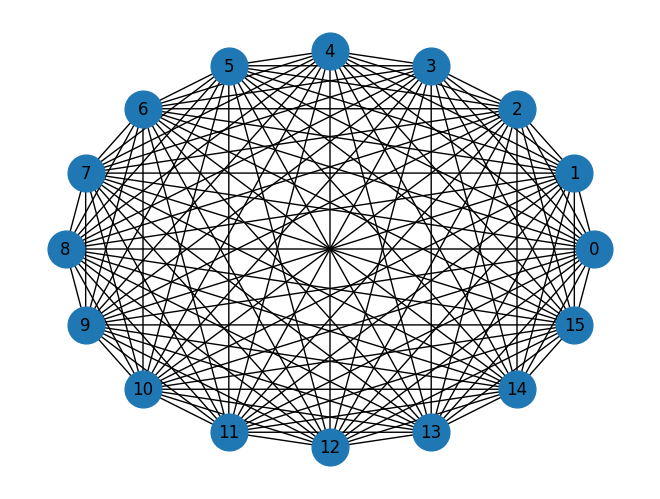

In [38]:
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True, node_size=700)

In [39]:
np.math.comb(l_events,2)

120

# TWO PROBLEMS TO SOLVE:
Only add an edge -- in G if there is a <--> between the notes in the digraph.
All nodes must be connected to each other.
If you want to be strict intersect with the atMostOnce
If there are cuts to be discovered in the mutual exclusion algorithm then it becomes a choice in relation to some optimization as to which subprocess to create.

Nothing works anymore.

TODO: implement my own simplicity and control flow complexity and some precission recall, F1 score bla bla bla

In [90]:
dcr = dcr1
adj_df = pd.DataFrame(columns=sorted(dcr['events']),index=sorted(dcr['events']),dtype=int)
adj_df = adj_df.fillna(0)
for e1 in dcr['events']:
    for e2 in dcr['events']:
        if e1 in dcr['excludesTo'] and e2 in dcr['excludesTo'][e1]:
            adj_df.loc[e1,e2] = 1
        if e2 in dcr['excludesTo'] and e1 in dcr['excludesTo'][e2]:
            adj_df.loc[e2,e1] = 1
adj_df = adj_df.astype(int)

In [91]:
adj_df

,A,B,X,Y,Z
A,0,0,1,0,0
B,0,0,0,0,0
X,1,1,1,1,0
Y,1,0,1,1,0
Z,1,0,0,0,0


In [92]:
adj_df.T

,A,B,X,Y,Z
A,0,0,1,1,1
B,0,0,1,0,0
X,1,0,1,1,0
Y,0,0,1,1,0
Z,0,0,0,0,0


In [93]:
adj_df + adj_df.T

,A,B,X,Y,Z
A,0,0,2,1,1
B,0,0,1,0,0
X,2,1,2,2,0
Y,1,0,2,2,0
Z,1,0,0,0,0


# Scoring